In [167]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

# Load the mix

In [168]:
multitracks = mdb.load_multitracks(["Phoenix_ColliersDaughter"])

In [169]:
mix = next(multitracks)

In [170]:
sample_rate, mix_audio = wavfile.read(mix.mix_path)
mix_audio = mix_audio.mean(1)
mix_audio = mix_audio[sample_rate*8:int(-sample_rate*1.5)]

In [171]:
samples_per_period = 256
overlap = int(samples_per_period/2)

In [172]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

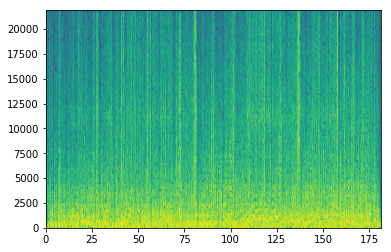

In [173]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))

# Load the Flute

In [174]:
flutes = mdb.get_files_for_instrument("flute", [mix])

In [175]:
flute = next(flutes)

In [176]:
sample_rate, flute_audio = wavfile.read(flute)
flute_audio = flute_audio.mean(1)
flute_audio = flute_audio[sample_rate*8:int(-sample_rate*1.5)]

In [177]:
freqs, times, s_flute = signal.stft(flute_audio, fs=sample_rate, nfft=samples_per_period, 
                                           noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_flute = s_flute[:-1,:]

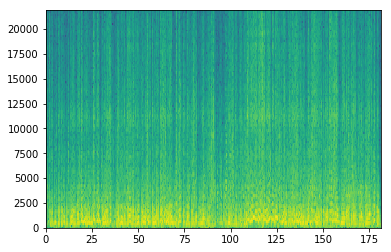

In [178]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_flute)))

## Create a mask for the flute

In [206]:
mask_flute = s_flute / (s_flute + s_mix + 1e-9)

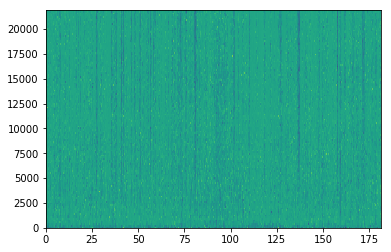

In [207]:
plt.pcolormesh(times, freqs, 20*np.log10(np.abs(mask_flute)))

# Prepare the training data

In [179]:
#s_mix_train = s_mix.reshape(*s_mix.T.shape, 1)
#s_mix_train.shape

In [180]:
num_test  = int((sample_rate * 10)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

60694 1722


In [208]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(60694, 128, 2)

In [209]:
flute_train = mask_flute.T[:num_train,:,np.newaxis]
flute_train = np.concatenate((flute_train.real, flute_train.imag), axis=-1)
flute_train.shape

(60694, 128, 2)

In [210]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(1722, 128, 2)

In [211]:
flute_test = mask_flute.T[-num_test:,:,np.newaxis]
flute_test = np.concatenate((flute_test.real, flute_test.imag), axis=-1)
flute_test.shape

(1722, 128, 2)

In [212]:
model = Sequential()

model.add(Conv1D(10, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_2"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 128, 10)           50        
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 128, 2)            42        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [213]:
model.compile('adam', loss='mean_squared_error', metrics=['accuracy'])

In [214]:
history = model.fit(mix_train, flute_train, batch_size=200, epochs=10)

Epoch 1/10
60694/60694 [==============================] - 18s 291us/step - loss: 181.5723 - acc: 0.5518
Epoch 2/10
60694/60694 [==============================] - 4s 62us/step - loss: 19.7310 - acc: 0.7052
Epoch 3/10
60694/60694 [==============================] - 4s 61us/step - loss: 10.5840 - acc: 0.7290
Epoch 4/10
60694/60694 [==============================] - 4s 62us/step - loss: 7.6092 - acc: 0.7471
Epoch 5/10
60694/60694 [==============================] - 4s 61us/step - loss: 6.1970 - acc: 0.7606
Epoch 6/10
60694/60694 [==============================] - 4s 66us/step - loss: 5.4173 - acc: 0.7697
Epoch 7/10
60694/60694 [==============================] - 4s 70us/step - loss: 4.9606 - acc: 0.7765
Epoch 8/10
60694/60694 [==============================] - 4s 68us/step - loss: 4.6810 - acc: 0.7815
Epoch 9/10
60694/60694 [==============================] - 4s 71us/step - loss: 4.4985 - acc: 0.7854
Epoch 10/10
60694/60694 [==============================] - 4s 65us/step - loss: 4.3767 - acc: 

In [215]:
results = model.evaluate(mix_test, flute_test)

print(model.metrics_names)
print(results)

1722/1722 [==============================] - 0s 158us/step
['loss', 'acc']
[0.6745871293697069, 0.7976009001853712]


# Results

In [228]:
mask_prediction = model.predict(mix_test)
mask_prediction.shape

(1722, 128, 2)

In [229]:
mask_prediction = np.sqrt((mask_prediction**2).sum(-1)).T

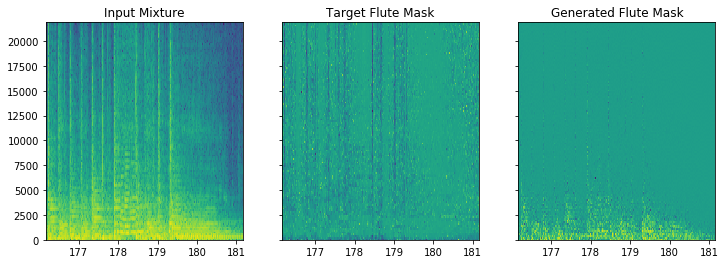

In [230]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target Flute Mask")
ax3.set_title("Generated Flute Mask")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(mask_flute[:,-num_test:])))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(mask_prediction))

In [233]:
target = s_mix[:,-num_test:] * mask_flute[:,-num_test:]

In [232]:
prediction = s_mix[:,-num_test:] * mask_prediction

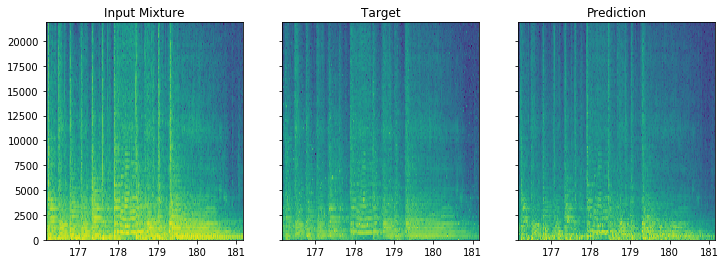

In [235]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [266]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)

In [267]:
wavfile.write("basic_model_flute_prediction.wav", sample_rate, predicted_audio.astype(np.int16))

In [268]:
_, target_audio = signal.istft(target, fs=sample_rate)

In [269]:
wavfile.write("basic_model_flute_target.wav", sample_rate, target_audio.astype(np.int16))

In [270]:
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

In [271]:
wavfile.write("basic_model_original.wav", sample_rate, mix_audio.astype(np.int16))